In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import matplotlib.image as mpimg
import time
import gc

In [2]:

# improve the ploting style
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 22
rcParams['mathtext.fontset'] = 'stix'

torch.Size([50000, 10]) torch.Size([10000, 10])


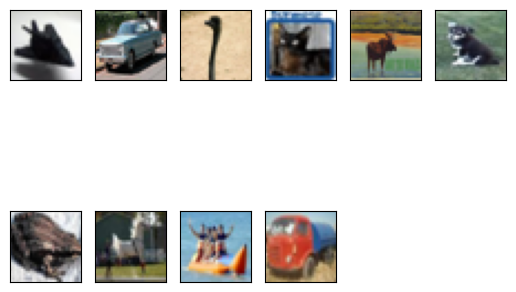

torch.Size([10000, 32, 32, 3]) torch.Size([10000, 1]) tensor([[1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.]]) torch.Size([2000, 32, 32, 3]) torch.Size([2000, 1])


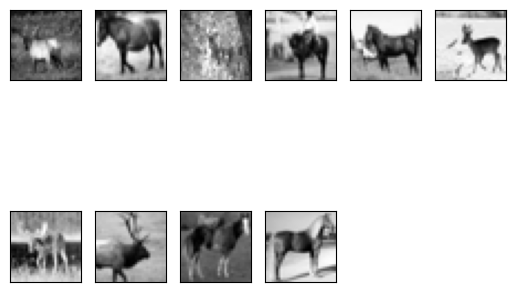

torch.Size([10000, 1024]) torch.Size([2000, 1024])


In [3]:
dtype = torch.float32

transform_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # Apply the (x - mean)/var operation on the components of the data # if x is in [0,1] then Normalise(x) is in [-1,1] # is applied on the three channels RGB
])

# Data import
dtype = torch.float32
trainset = torchvision.datasets.CIFAR10(root = './datas', train= True, download = True, transform = transform_data)
validset = torchvision.datasets.CIFAR10(root = './datas', train = False, download = True, transform = transform_data)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 1)

x_train, y_train_raw, x_valid, y_valid_raw = torch.tensor(trainset.data), torch.tensor(trainset.targets), torch.tensor(validset.data), torch.tensor(validset.targets)

# Modification du format des données shape (n_data,1) -> (n_data, n_classes)
y_train = torch.zeros((y_train_raw.shape[0], torch.max(y_train_raw)+1))
for i, y in enumerate(y_train_raw):
    j = int(y.item())
    y_train[i,j] = 1

y_valid = torch.zeros((y_valid_raw.shape[0], torch.max(y_valid_raw)+1))
for i,y in enumerate(y_valid_raw):
    j = int(y.item())
    y_valid[i,j] = 1 
print(y_train.shape, y_valid.shape)

# Binary reduction of the classes # To avoid using softmax, we regroup classes in two classes
class_binary_reduction = True
determination_des_classes = True
black_and_white_images = True

if class_binary_reduction :
    if determination_des_classes :
        # Determination des classes
        class_list = []
        class_index = 0
        for i in range (x_train.shape[0]):
            if y_train[i, class_index] == 1:
                class_list.append(x_train[i])
                class_index += 1
            if len(class_list) == len(y_train[0]):
                break
        for i, image in enumerate(class_list):
            plt.subplot(2, int(len(class_list)/2+1),i+1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
        plt.show()
                
    # classe1 = [0, 1, 8, 9]  # vehicles
    # classe2 = [2, 3, 4, 5]  # animals
    
    classe1 = [4]  # elk
    classe2 = [7]  # horse

    # Création des masques pour les échantillons appartenant à ces classes
    mask_classe1_train = y_train[:, classe1].sum(dim=1) > 0  # True si appartient à classe1
    mask_classe2_train = y_train[:, classe2].sum(dim=1) > 0  # True si appartient à classe2
    
    mask_classe1_valid = y_valid[:, classe1].sum(dim=1) > 0
    mask_classe2_valid = y_valid[:, classe2].sum(dim=1) > 0
    
    # Filtrage des exemples concernés
    mask_train = torch.logical_or(mask_classe1_train, mask_classe2_train)
    mask_valid = torch.logical_or(mask_classe1_valid, mask_classe2_valid)
    x_train, y_train = x_train[mask_train], y_train[mask_train]
    x_valid, y_valid = x_valid[mask_valid], y_valid[mask_valid]

    # Création du vecteur de labels binaires (1 pour classe1, 0 pour classe2)
    y_train = (y_train[:, classe1].sum(dim=1) > 0).to(dtype).unsqueeze(1)
    y_valid = (y_valid[:, classe1].sum(dim=1) > 0).to(dtype).unsqueeze(1)
    
    # Avec tanh
    
    # x_train = 2*(x_train-0.5)
    # y_train = 2*(y_train-0.5)
    # x_valid = 2*(x_valid-0.5)
    # y_valid = 2*(y_valid-0.5)

    print(x_train.shape, y_train.shape, y_train[0:10], x_valid.shape, y_valid.shape)

if black_and_white_images :
    x_train = 0.299*x_train[:,:,:,0] + 0.587*x_train[:,:,:,1] + 0.114*x_train[:,:,:,2]
    x_valid = 0.299*x_valid[:,:,:,0] + 0.587*x_valid[:,:,:,1] + 0.114*x_valid[:,:,:,2]
    for i, image in enumerate(x_train[0:10]):
        plt.subplot(2, int(len(x_train[0:10])/2+1),i+1)
        plt.imshow(image, cmap = 'grey')
        plt.xticks([])
        plt.yticks([])
    plt.show()
    x_train, x_valid = (x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])).to(dtype), x_valid.reshape(x_valid.shape[0], x_valid.shape[1]*x_valid.shape[2]).to(dtype)
    print(x_train.shape, x_valid.shape)

else :    
    x_train, x_valid = (x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]*x_train.shape[3])).to(dtype), x_valid.reshape(x_valid.shape[0], x_valid.shape[1]*x_valid.shape[2]*x_valid.shape[3]).to(dtype)
    print(x_train.shape, x_valid.shape)

In [16]:
dtype = torch.float32

if torch.backends.mps.is_available():
    device = torch.device("mps")
else :
    device = torch.device("cpu")
print("Computing on : ", device)

def ReLU(x):
    return torch.max(torch.tensor(0).to(device),x)

def ReLU_derivative(x):
    return (x>0).type(dtype).to(device)

def softmax_derivative(s):
    """
    s : Tensor de shape (n_batch, num_classes), déjà softmaxé
    Renvoie : Tensor de shape (n_batch, num_classes, num_classes) contenant la jacobienne de softmax pour chaque échantillon
    """
    s = s.to(device)
    n, C = s.shape
    jacobians = torch.zeros(n, C, C, dtype=s.dtype).to(device) # Initialisation du tenseur Jacobien (n_batch, num_classes, num_classes) => (i,j,k) = dérivée de softmax au logit j du ième batch par rapport au logit k du même batch
    for i in range(n):  # Pour chaque échantillon du batch, on calcule la jacobienne de softmax
        si = s[i].unsqueeze(1)  # shape (C, 1) # vecteur softmax(logits) pour la i-ème donnée du batch
        jacobians[i] = torch.diagflat(si) - torch.mm(si,si.t()) # calcul de la jacobienne (matrice des dérivées croisées) de softmax au point z_i = vect(logits_i) # shape (C, C) -> Indice du Jacobien : lignes, Indice des logits : colonnes
    return jacobians

def sigmoid(x):
    return 1/(1+torch.exp(-x))

def sigmoid_derivative(x):
    return torch.exp(-x)/((1 + torch.exp(-x))**2)

def tanh_derivative(x):
    return (1 - (torch.tanh(x)**2)).to(device)

class two_layer_NN(nn.Module):
    def __init__(self,input_dimension,hidden_1_size,number_of_classes,lr=1e-3, reg1 = 0, reg2 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 100):
        """
        Constructor of the two-layer neural network class.
        """
        super(two_layer_NN,self).__init__()
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.number_of_classes = number_of_classes
        self.lr = lr
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        self.training_time = 0
        # Initializing layers and bias        
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = self.eps_init*torch.randn(number_of_classes, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(number_of_classes,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        # Initializing Softmax
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x):
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, number_of_classes ) # logits layer 2
        output = self.softmax(z2) # output layer # shape (n_data, number_of_classes)
        return output, z2, h1, z1
    
    # coef_iter est a ajusté en fonction du seuil kappa_eff d'apprentissage des données.
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, reg1=0, reg2=0, eps_init=1, fraction_batch=0.01, observation_rate = 100, train_layer_1 = True, train_layer_2 = True):
        # Initializing the training chronometer
        start = time.time()
        unwanted_time = 0
        # Initializing training parameters
        self.architecture = "2 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch) 
        self.lr = lr
        self.reg1 = reg1
        self.reg2 = reg2
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        # Moving training and validation datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)
        
        for i in range(N_iterations):
            # Sélection un lot de données aléatoires parmis les données d'entrainement 
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] 
            # Calcul de la prédiction
            output, z2, h1, z1 = self.forward(x_minibatch)
            
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                training_loss = torch.mean(0.5*(output - y_minibatch)**2) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean((torch.argmax(self.forward(x_valid)[0], dim=1) == torch.argmax(y_valid, dim=1)).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
                
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = output - y_minibatch; grad_output = grad_output.to(dtype)
            grad_z2 = torch.einsum('noz, no->nz', softmax_derivative(output), grad_output); grad_z2  = grad_z2.to(dtype) # shape(n_data, num_classes) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h1 = torch.mm(grad_z2, self.W2); grad_h1  = grad_h1.to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = grad_h1*ReLU_derivative(z1); grad_z1  = grad_z1.to(dtype) # shape (n_data, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            
            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            del x_minibatch, y_minibatch, output, z2, h1, z1, grad_output, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2
            gc.collect()
        
        # Calcul de la durée de l'entraînement    
        self.training_time = time.time() - start - unwanted_time
        return "Training done"
   
class three_layer_NN(nn.Module):
    def __init__(self, input_dimension, hidden_1_size, hidden_2_size, number_of_classes,lr=0.01, reg1 =0, reg2 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 10):
        """
        Constructor of the three-layer neural network class.
        """
        super(three_layer_NN,self).__init__()
        # Initialisation des propriétés du réseau
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.hidden_2_size = hidden_2_size
        self.number_of_classes = number_of_classes
        self.lr = lr
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        
        # Initialisation de la propriété durée d'entrainement
        self.training_time = 0
        
        # Initialisation des couches et des biais du réseau
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = eps_init*torch.randn(hidden_2_size, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.W3 = eps_init*torch.randn(number_of_classes, hidden_2_size, dtype=dtype)/np.sqrt(hidden_2_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(hidden_2_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        self.b3 = eps_init*(2*torch.rand(number_of_classes,1,dtype=dtype)-1)
        
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.W3 = self.W3.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        self.b3 = self.b3.to(device)
        
        # Initializing Softmax
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x):
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, number_of_classes ) # logits layer 2
        h2 = ReLU(z2) # hidden neurons layer 2
        z3 = (torch.mm(self.W3,h2.t()) + self.b3).t()
        output = self.softmax(z3) # output layer # shape (n_data, number_of_classes)
        return output, z3, h2, z2, h1, z1
    
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, reg1 = 0, reg2 = 0, reg3 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 10, train_layer_1 = True, train_layer_2 = True, train_layer_3 = True):
        # Initializing training chronometer
        start = time.time()
        unwanted_time = 0
        # Initializing training parameters
        self.architecture = "3 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - Training third layer : " + str(train_layer_3) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch)
        self.lr = lr
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        # Moving input datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)        
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        
        for i in range(N_iterations):
            
            # Tirage aléatoire d'un minibatch
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] # sélection un lot de données aléatoires parmis les données d'entrainement 
            
            # Calcul de la prédiction
            output, z3, h2, z2, h1, z1 = self.forward(x_minibatch)
            
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                training_loss = torch.mean(0.5*(output - y_minibatch)**2) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean((torch.argmax(self.forward(x_valid)[0], dim=1) == torch.argmax(y_valid, dim=1)).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
            
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 + reg3*(||W3||**2 + ||b3||**2) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = (output - y_minibatch).to(dtype)
            grad_z3 = (torch.einsum('no,noz->nz',grad_output,softmax_derivative(output))).to(dtype) # shape (n_data, num_classes) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h2 = (torch.mm(grad_z3, self.W3)).to(dtype) # shape (n_data, hidden_2_size)
            grad_z2 = (grad_h2*ReLU_derivative(z2)).to(dtype) # shape(n_data, hidden_2_size)         
            grad_h1 = (torch.mm(grad_z2, self.W2)).to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = (grad_h1*ReLU_derivative(z1)).to(dtype) # shape (n_data, hidden_1_size)
            
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            # Calcul de la moyenne empirique de dLoss/dW3 par backpropagation
            grad_W3 = (torch.mm(grad_z3.t(),h2)/x_minibatch.shape[0]).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation
            grad_b3 = (torch.mean(grad_z3,dim=0).unsqueeze(1)).to(dtype)
            
            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            if train_layer_3:
                self.W3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_W3/(eps_init**2) + self.reg3*self.W3)).to(dtype)
                self.b3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_b3/(eps_init**2) + self.reg3*self.b3)).to(dtype)
            del x_minibatch, y_minibatch, output, z3, h2, z2, h1, z1, grad_output, grad_z3, grad_h2, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3
            gc.collect()
        
        # Calcul de la durée d'entrainement
        self.training_time = time.time() - start - unwanted_time
        return "Training done"

class binary_classification_two_layer_NN(nn.Module):
    def __init__(self,input_dimension,hidden_1_size,lr=1e-3, reg1 = 0, reg2 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 100):
        """
        Constructor of the two-layer neural network class.
        """
        super(binary_classification_two_layer_NN,self).__init__()
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.lr = lr
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        self.training_time = 0
        # Initializing layers and bias        
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = self.eps_init*torch.randn(1, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(1,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x):
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, number_of_classes ) # logits layer 2
        output = torch.sigmoid(z2) # output layer # shape (n_data, number_of_classes)
        return output, z2, h1, z1
    
    # coef_iter est a ajusté en fonction du seuil kappa_eff d'apprentissage des données.
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, reg1=0, reg2=0, eps_init=1, fraction_batch=0.01, observation_rate = 100, train_layer_1 = True, train_layer_2 = True):
        # Initializing the training chronometer
        start = time.time()
        unwanted_time = 0
        # Initializing training parameters
        self.architecture = "2 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch) 
        self.lr = lr
        self.reg1 = reg1
        self.reg2 = reg2
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        # Moving training and validation datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)
        
        for i in range(N_iterations):
            # Sélection un lot de données aléatoires parmis les données d'entrainement 
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] 
            # Calcul de la prédiction
            output, z2, h1, z1 = self.forward(x_minibatch)
            #print(output[0:5], z2[0:5], h1[0:5], z1[0:5])
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                print("Output", output[20:22])
                training_loss = torch.mean(0.5*(output - y_minibatch)**2)
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean(((self.forward(x_valid)[0] > 0.5).to(dtype) == y_valid).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
                
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = output - y_minibatch; grad_output = grad_output.to(dtype)
            grad_z2 = grad_output*sigmoid_derivative(z2); grad_z2  = grad_z2.to(dtype) # shape(n_data, 1)
            grad_h1 = torch.mm(grad_z2, self.W2); grad_h1  = grad_h1.to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = grad_h1*ReLU_derivative(z1); grad_z1  = grad_z1.to(dtype) # shape (n_data, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            
            # if i == 250:
            #     break

            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            del x_minibatch, y_minibatch, output, z2, h1, z1, grad_output, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2
            gc.collect()
        
        # Calcul de la durée de l'entraînement    
        self.training_time = time.time() - start - unwanted_time
        return "Training done"
    
class binary_classification_three_layer_NN(nn.Module):
    def __init__(self, input_dimension, hidden_1_size, hidden_2_size, lr=0.01, decay_rate = 0, reg1 =0, reg2 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 10):
        """
        Constructor of the three-layer neural network class.
        """
        super(binary_classification_three_layer_NN,self).__init__()
        # Initialisation des propriétés du réseau
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.hidden_2_size = hidden_2_size
        self.lr = lr
        self.decay_rate = decay_rate
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        
        # Initialisation de la propriété durée d'entrainement
        self.training_time = 0
        
        # Initialisation des couches et des biais du réseau
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = eps_init*torch.randn(hidden_2_size, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.W3 = eps_init*torch.randn(1, hidden_2_size, dtype=dtype)/np.sqrt(hidden_2_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(hidden_2_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        self.b3 = eps_init*(2*torch.rand(1,1,dtype=dtype)-1)
        
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.W3 = self.W3.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        self.b3 = self.b3.to(device)
        
        # Initializing Softmax
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x):
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, hidden_2_size ) # logits layer 2
        h2 = ReLU(z2) # hidden neurons layer 2
        z3 = (torch.mm(self.W3,h2.t()) + self.b3).t() # shape (n_data, 1)
        output = sigmoid(z3) # output layer # shape (n_data, 1)
        return output, z3, h2, z2, h1, z1
    
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, decay_rate = 0, reg1 = 0, reg2 = 0, reg3 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 10, train_layer_1 = True, train_layer_2 = True, train_layer_3 = True, dropout_rate = 0):
        # Initializing training chronometer
        start = time.time()
        unwanted_time = 0
        # Initializing training parameters
        self.architecture = "3 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - Training third layer : " + str(train_layer_3) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - decay_rate " + str(decay_rate) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch)
        self.lr = torch.tensor(lr)
        self.decay_rate = decay_rate
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        # Moving input datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)        
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        
        for i in range(N_iterations):
            
            # Tirage aléatoire d'un minibatch
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] # sélection un lot de données aléatoires parmis les données d'entrainement 
            
            # Dropout
            # dropout_mask = (torch.rand((minibatch_size, x_train.shape[1])) > dropout_rate).to(dtype)
            # x_minibatch = x_minibatch*dropout_mask
            
            # Calcul de la prédiction
            output, z3, h2, z2, h1, z1 = self.forward(x_minibatch)
            
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                training_loss = torch.mean(0.5*(output - y_minibatch)**2) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean(((self.forward(x_valid)[0] > 0.5).to(dtype) == y_valid).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
            
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 + reg3*(||W3||**2 + ||b3||**2) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = (output - y_minibatch).to(dtype)
            grad_z3 = grad_output*sigmoid_derivative(z3).to(dtype) # shape (n_data, 1) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h2 = (torch.mm(grad_z3, self.W3)).to(dtype) # shape (n_data, hidden_2_size)
            grad_z2 = (grad_h2*ReLU_derivative(z2)).to(dtype) # shape(n_data, hidden_2_size)         
            grad_h1 = (torch.mm(grad_z2, self.W2)).to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = (grad_h1*ReLU_derivative(z1)).to(dtype) # shape (n_data, hidden_1_size)
            
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            # Calcul de la moyenne empirique de dLoss/dW3 par backpropagation
            grad_W3 = (torch.mm(grad_z3.t(),h2)/x_minibatch.shape[0]).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation
            grad_b3 = (torch.mean(grad_z3,dim=0).unsqueeze(1)).to(dtype)
            
            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            if train_layer_3:
                self.W3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_W3/(eps_init**2) + self.reg3*self.W3)).to(dtype)
                self.b3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_b3/(eps_init**2) + self.reg3*self.b3)).to(dtype)
            del x_minibatch, y_minibatch, output, z3, h2, z2, h1, z1, grad_output, grad_z3, grad_h2, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3
            gc.collect()
            
            self.lr = lr*torch.exp(torch.tensor(-i/self.decay_rate))
            # if i == 12000:
            #     break
        
        # Calcul de la durée d'entrainement
        self.training_time = time.time() - start - unwanted_time
        return "Training done"
    
    
    

Computing on :  mps


In [5]:
binary_model_2_layer = binary_classification_two_layer_NN(1024, 512, eps_init = 1e-3)

In [7]:
binary_model_2_layer.train_layers(x_train,y_train, x_valid, y_valid, 1.6, 1e-9, 0.1, 0.1, 1e-1, 0.01, 10)

For kappa = 1.6, the number of datas used for the training is 6553600.000000005 and the number of iterations is 65536.
Output tensor([[0.5301],
        [0.5135]], device='mps:0')
Iteration 0 Training loss 0.1261061280965805 Validation loss 0.12592941522598267 Accuracy 0.5035000443458557
Output tensor([[0.5129],
        [0.5191]], device='mps:0')
Iteration 10 Training loss 0.1250447779893875 Validation loss 0.12558652460575104 Accuracy 0.5125000476837158
Output tensor([[0.5045],
        [0.4935]], device='mps:0')
Iteration 20 Training loss 0.12453171610832214 Validation loss 0.12518012523651123 Accuracy 0.492000013589859
Output tensor([[0.5001],
        [0.4938]], device='mps:0')
Iteration 30 Training loss 0.12535317242145538 Validation loss 0.12507618963718414 Accuracy 0.47600001096725464
Output tensor([[0.4898],
        [0.4966]], device='mps:0')
Iteration 40 Training loss 0.12619490921497345 Validation loss 0.12493804097175598 Accuracy 0.47450003027915955
Output tensor([[0.4933],
   

'Training done'

In [17]:
binary_model_3_layer = binary_classification_three_layer_NN(1024, 512, 512, eps_init = 1e-3)

In [ ]:
binary_model_3_layer.train_layers(x_train, y_train, x_valid, y_valid, 1.6, 1e-2, 5e3, 0.1, 0.1, 0.1, 1, 0.01, 10) 

For kappa = 1.6, the number of datas used for the training is 6553600.000000005 and the number of iterations is 65536.
Iteration 0 Training loss 0.12500135600566864 Validation loss 0.12500105798244476 Accuracy 0.453000009059906
Iteration 10 Training loss 0.12497668713331223 Validation loss 0.12497969716787338 Accuracy 0.49900001287460327
Iteration 20 Training loss 0.1250060647726059 Validation loss 0.12500512599945068 Accuracy 0.5
Iteration 30 Training loss 0.12621861696243286 Validation loss 0.12476550787687302 Accuracy 0.5
Iteration 40 Training loss 0.12500697374343872 Validation loss 0.12500706315040588 Accuracy 0.5
Iteration 50 Training loss 0.12502515316009521 Validation loss 0.12502530217170715 Accuracy 0.5
Iteration 60 Training loss 0.12473168969154358 Validation loss 0.12463594973087311 Accuracy 0.5400000214576721
Iteration 70 Training loss 0.12545019388198853 Validation loss 0.125022754073143 Accuracy 0.5
Iteration 80 Training loss 0.1253579705953598 Validation loss 0.12503279

'Training done'

In [38]:
binary_model_3_layer_1_untrained = binary_classification_three_layer_NN(3072, 2048, 2048, eps_init = 1e-3)

In [39]:
binary_model_3_layer_1_untrained.train_layers(x_train, y_train, x_valid, y_valid, 1.5, 1e-3, 0, 0, 0, 1, 0.01, 10, True, False, True) 

For kappa = 1.5, the number of datas used for the training is 17026752.25872509 and the number of iterations is 42566.
Iteration 0 Training loss 0.12500081956386566 Validation loss 0.1250009983778 Accuracy 0.5
Iteration 10 Training loss 0.12426601350307465 Validation loss 0.12450466305017471 Accuracy 0.5
Iteration 20 Training loss 0.12398973107337952 Validation loss 0.12418626993894577 Accuracy 0.5
Iteration 30 Training loss 0.1239936351776123 Validation loss 0.12389950454235077 Accuracy 0.5003750324249268
Iteration 40 Training loss 0.12299794703722 Validation loss 0.12358492612838745 Accuracy 0.5003750324249268
Iteration 50 Training loss 0.1238676980137825 Validation loss 0.12329433858394623 Accuracy 0.5015000104904175
Iteration 60 Training loss 0.12382584065198898 Validation loss 0.12299849838018417 Accuracy 0.5056250095367432
Iteration 70 Training loss 0.12160582095384598 Validation loss 0.12270954251289368 Accuracy 0.5121250152587891
Iteration 80 Training loss 0.12226653844118118 V

'Training done'

In [254]:
model_2_layer = two_layer_NN(3072,2048,10, 1)

In [ ]:
model_2_layer.train_layers(x_train,y_train, x_valid, y_valid, 2, 1e-5, 0, 0, 1, 0.01, 10)

In [ ]:
model_3_trained_layer = three_layer_NN(784, 512, 512, 10)

In [ ]:
model_3_trained_layer.train_layers(x_train, y_train, x_valid, y_valid, 2, 1e-3, 0, 0, 0, 1, 0.01, 10)

In [24]:
model_3_layer_1_untrained = three_layer_NN(784, 2048, 2048, 10)

In [ ]:
model_3_layer_1_untrained.train_layers(x_train, y_train, x_valid, y_valid, 2, 1e-3, 0, 0, 0, 1, 0.01, 10, True, False, True)

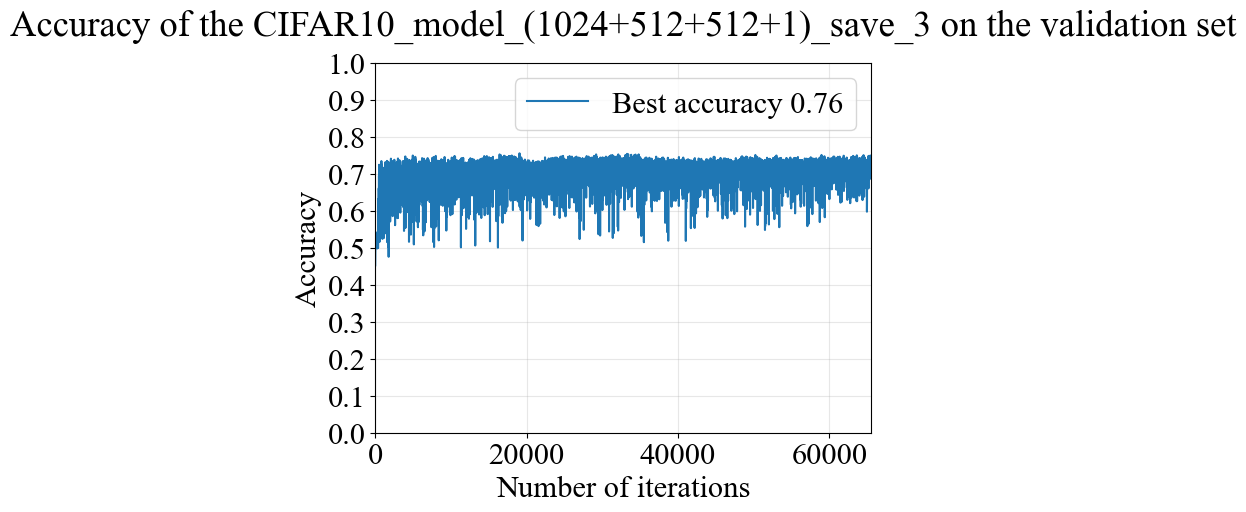

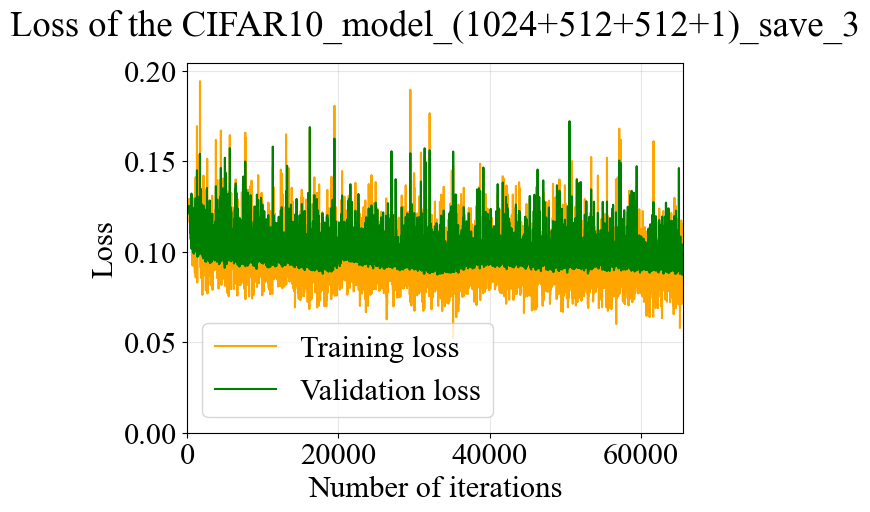

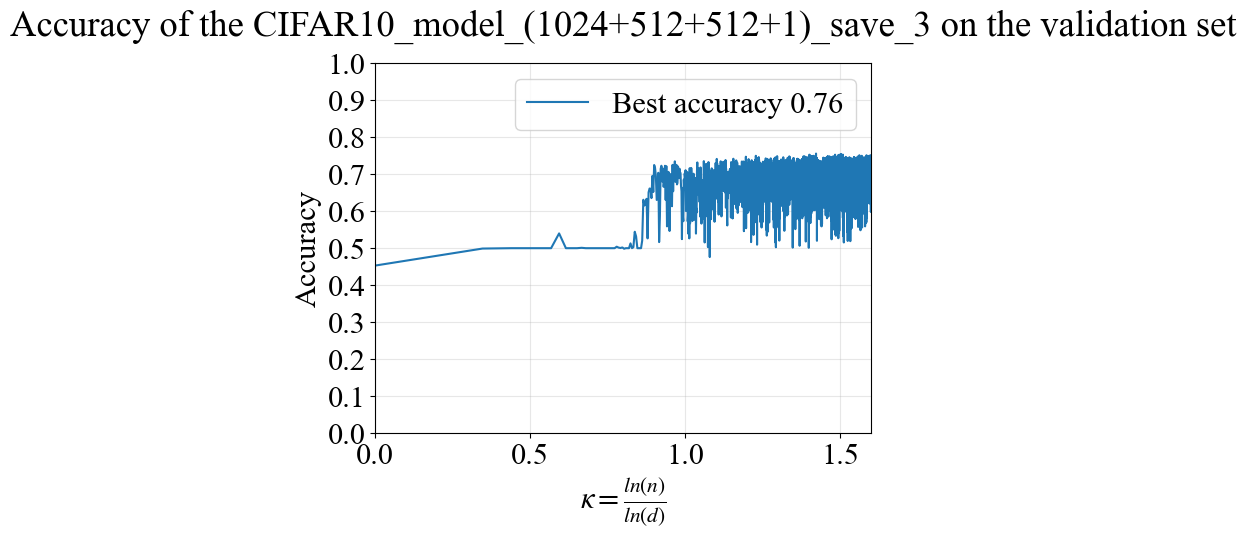

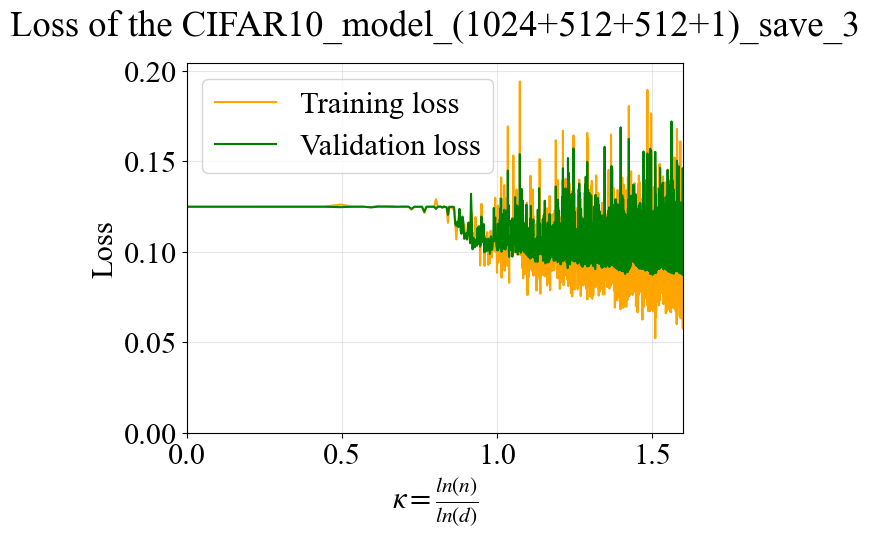

In [19]:
save = True
date = "06_05_25_"
if save :
    # Save the model
    model = binary_model_3_layer
    model_name = "CIFAR10_model_(1024+512+512+1)_save_3"
    save_path = "Classifiers/" + date + model_name + "/"
    os.makedirs(save_path, exist_ok=True)
    torch.save(model , save_path + model_name + ".pt")


    # Save Architecture
    with open(save_path + "architecture.txt", "w", encoding="utf-8") as f:
        f.write(model.architecture + str(model.training_time))

    # Save performances of the model
    os.makedirs(save_path + "figures/", exist_ok=True) 
    # Plot accuracy = f(n)
    plt.plot(np.linspace(0, len(model.accuracy_trajectory)*model.observation_rate, len(model.accuracy_trajectory)), model.accuracy_trajectory, label = "Best accuracy " + str(np.round(np.max(model.accuracy_trajectory), 2)))
    plt.xlim(0, len(model.accuracy_trajectory)*model.observation_rate)
    plt.ylim(0,1)
    plt.yticks(np.linspace(0,1,11))
    plt.xlabel("Number of iterations")  
    plt.ylabel("Accuracy")
    plt.grid(alpha=0.3)
    plt.title("Accuracy of the " + model_name + " on the validation set", pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/accuracy_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/accuracy_of_" + model_name + ".svg", bbox_inches='tight')
    data = np.column_stack((np.linspace(0, len(model.accuracy_trajectory)*model.observation_rate, len(model.accuracy_trajectory)), model.accuracy_trajectory)) 
    np.savetxt(save_path +"figures/accuracy_of_" + model_name + ".txt", data, delimiter =",", header="n,accuracy")
    plt.show() 
    
    # Plot training and validation loss = f(n)
    plt.plot(np.linspace(0,len(model.training_loss_trajectory)*model.observation_rate, len(model.training_loss_trajectory)), model.training_loss_trajectory, label = "Training loss", color = "orange")
    plt.plot(np.linspace(0,len(model.validation_loss_trajectory)*model.observation_rate, len(model.validation_loss_trajectory)), model.validation_loss_trajectory, label="Validation loss", color = "green")
    plt.xlim(0, len(model.training_loss_trajectory)*model.observation_rate)
    plt.ylim(0, np.max([model.training_loss_trajectory, model.validation_loss_trajectory])+0.01)
    plt.xlabel("Number of iterations")  
    plt.ylabel("Loss")
    plt.grid(alpha=0.3)
    plt.title("Loss of the " + model_name, pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/loss_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/loss_of_" + model_name + ".svg", bbox_inches='tight')
    data = np.column_stack((np.linspace(0,len(model.training_loss_trajectory)*model.observation_rate, len(model.training_loss_trajectory)), model.training_loss_trajectory))
    np.savetxt(save_path + "figures/loss_training_" + model_name + ".txt", data, delimiter=",", header="n, training_loss")
    plt.show()
    
    # Plot accuracy = f(kappa)
    kappa = [np.log(n)/np.log(model.input_dimension) for n in np.linspace(1, len(model.accuracy_trajectory)*model.observation_rate+1, len(model.accuracy_trajectory))]
    plt.plot(kappa, model.accuracy_trajectory, label = "Best accuracy " + str(np.round(np.max(model.accuracy_trajectory), 2)))
    plt.xlim(0, np.max(kappa))
    plt.ylim(0,1)
    plt.yticks(np.linspace(0,1,11))
    plt.xlabel(r"$\kappa  = \frac{ln(n)}{ln(d)}$")  
    plt.ylabel("Accuracy")
    plt.grid(alpha=0.3)
    plt.title("Accuracy of the " + model_name + " on the validation set", pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/kappa_accuracy_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/kappa_accuracy_of_" + model_name + ".svg", bbox_inches='tight')
    data = np.column_stack((kappa, model.accuracy_trajectory))
    np.savetxt(save_path + "figures/kappa_accuracy_" + model_name + ".txt", data, delimiter=",", header="kappa, accuracy")
    plt.show()
    
    # Plot training and validation loss
    kappa = [np.log(n)/np.log(model.input_dimension) for n in np.linspace(1, len(model.training_loss_trajectory)*model.observation_rate, len(model.training_loss_trajectory))]
    plt.plot(kappa, model.training_loss_trajectory, label = "Training loss", color = "orange")
    plt.plot(kappa, model.validation_loss_trajectory, label = "Validation loss", color = "green")
    plt.xlim(0, np.max(kappa))
    plt.ylim(0, np.max([model.training_loss_trajectory, model.validation_loss_trajectory])+0.01)
    plt.xlabel(r"$\kappa  = \frac{ln(n)}{ln(d)}$")  
    plt.ylabel("Loss")
    plt.grid(alpha=0.3)
    plt.title("Loss of the " + model_name, pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/kappa_loss_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/kappa_loss_of_" + model_name + ".svg", bbox_inches='tight')
    data_training = np.column_stack((kappa, model.training_loss_trajectory))
    np.savetxt(save_path + "figures/kappa_loss_training_" + model_name + ".txt", data_training, delimiter=",", header="kappa, training_loss")
    data_validation = np.column_stack((kappa, model.validation_loss_trajectory))
    np.savetxt(save_path + "figures/kappa_loss_validation_" + model_name + ".txt", data_validation, delimiter=",", header="kappa, validation_loss")
    plt.show()
    
else:
    print("No save")


In [ ]:
os.makedirs("datas\models")

0.001
tensor(0.8692)


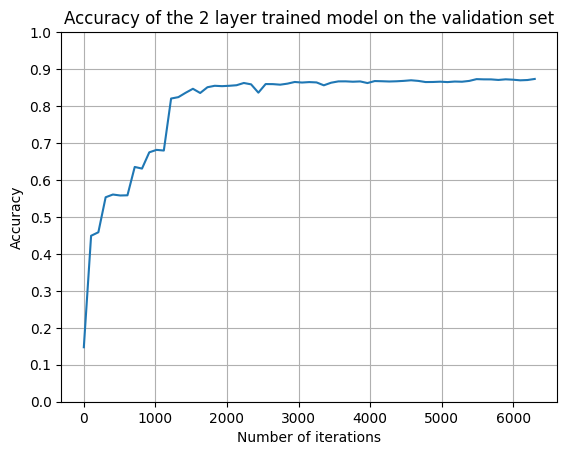

<Figure size 640x480 with 0 Axes>

In [ ]:
# Import model and plot performances

model_name = "model_2_layer_trained_save_1"
assessed_model = torch.load("datas/models/model_2_layer_save_1.pt", weights_only=False)

# Details of the model
print(assessed_model.architecture)

# Plots of performances
accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
plt.imshow(accuracy)
kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
plt.imshow(kappa_accuracy)
loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
plt.imshow(loss)
kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
plt.imshow(kappa_loss)
plt.show()

# Import datas
accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)


In [ ]:
dtype = torch.float32

def ReLU(x):
    return torch.max(torch.tensor(0),x)

def ReLU_derivative(x):
    return (x>0).to(dtype)

def softmax_derivative(s):
    """
    s : Tensor de shape (n_batch, num_classes), déjà softmaxé
    Renvoie : Tensor de shape (n_batch, num_classes, num_classes) contenant la jacobienne de softmax pour chaque échantillon
    """
    n, C = s.shape
    jacobians = torch.zeros(n, C, C, dtype=s.dtype) # Initialisation du tenseur Jacobien (n_batch, num_classes, num_classes) => (i,j,k) = dérivée de softmax au logit j du ième batch par rapport au logit k du même batch
    for i in range(n):  # Pour chaque échantillon du batch, on calcule la jacobienne de softmax
        si = s[i].unsqueeze(1)  # shape (C, 1) # vecteur softmax(logits) pour la i-ème donnée du batch
        jacobians[i] = torch.diagflat(si) - torch.mm(si,si.t()) # calcul de la jacobienne (matrice des dérivées croisées) de softmax au point z_i = vect(logits_i) # shape (C, C) -> Indice du Jacobien : lignes, Indice des logits : colonnes
    return jacobians



class three_layer_NN(nn.Module):
    def __init__(self,input_dimension,hidden_1_size,number_of_classes,lr=1e-3, reg1 = 0, reg2 = 0, reg3 = 0, esp_init = 1, fraction_batch=0.01):
        """
        Constructor of the two-layer neural network class.
        """
        super(two_layer_NN,self).__init__()
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.number_of_classes = number_of_classes
        self.lr = lr
        self.eps_init = esp_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.fraction_batch = fraction_batch
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = self.eps_init*torch.randn(number_of_classes, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = esp_init*(2*torch.rand(number_of_classes,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x):
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, number_of_classes ) # logits layer 2
        h2 = ReLU(z2) # # hidden neurons layer 2
        z3 = torch.mm(self.W3, h2.t() + self.b3)
        output = self.softmax(z2) # output layer # shape (n_data, number_of_classes)
        return output, z2, h1, z1
    
    # coef_iter est a ajusté en fonction du seuil kappa_eff d'apprentissage des données.
    def train_layers(self, x_train, y_train, x_valid, y_valid, coef_iter = 1, lr=1e-3, reg1 = 0, reg2 = 0, reg3 = 0, eps_init=0.2, fraction_batch=1e-2, train_layer1=True, train_layer2=True, train_layer3=True):
        self.lr = lr
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        kappa_max = 1 + coef_iter
        max_iter = self.input_dimension**(kappa_max)
        print("max_iter", max_iter)
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_minibatches = int(max_iter / self.fraction_batch) # Nombre de minibatches utilisés pour l'apprentissage de la première couche
        for i in range(N_minibatches):
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] # sélection un lot de données aléatoires parmis les données d'entrainement 
            # Calcul de la prédiction
            output, z2, h1, z1 = self.forward(x_minibatch)
            # Suivi de l'apprentissage
            if i % 100 == 0:
                training_loss = torch.mean(0.5*(output - y_minibatch)**2, dim=0) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                overall_training_loss = torch.mean(training_loss,dim=0)
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2, dim=0)
                overall_validation_loss = torch.mean(validation_loss,dim=0)
                self.training_loss_trajectory.append(overall_training_loss.item())
                self.validation_loss_trajectory.append(overall_validation_loss.item())
                accuracy = torch.mean((torch.argmax(self.forward(x_valid)[0], dim=1) == torch.argmax(y_valid, dim=1)).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", overall_training_loss.item(), "Validation loss", overall_validation_loss.item(), "Accuracy", accuracy.item())
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            # Calcul des gradients
            grad_output = output - y_minibatch
            grad_z2 = torch.einsum('noz, no->nz', softmax_derivative(output), grad_output) # shape(n_data, num_classes) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h1 = torch.mm(grad_z2, self.W2)  # shape (n_data, hidden_1_size)
            grad_z1 = grad_h1*ReLU_derivative(z1) # shape (n_data, hidden_1_size)
            
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0] # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = torch.mean(grad_z1, dim=0).unsqueeze(1) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0] # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = torch.mean(grad_z2, dim=0).unsqueeze(1)
            
            # Mise à jours des paramètres de la première couche
            self.W1 -= self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/self.eps_init**2 + self.reg1*self.W1) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
            self.b1 -= self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/self.eps_init**2 + self.reg1*self.b1)
            self.W2 -= self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_W2/self.eps_init**2 +self.reg2*self.W2)
            self.b2 -= self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_b2/self.eps_init**2 + self.reg2*self.b2)
        return "Training done"
   
